## Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


---
## Step 1 Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images. 

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


C:\Users\xgu3\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


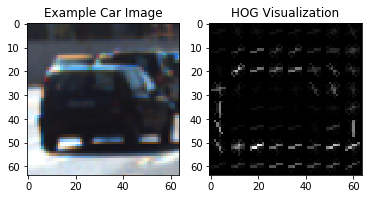

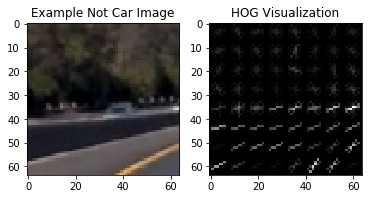

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

#explore data
car_images = glob.glob('./vehicles/*/*.png', recursive=True)
cars = []
for img in car_images:
    cars.append(img)

notcar_imsges = glob.glob('./non-vehicles/*/*.png', recursive=True)
notcars = []
for img in notcar_imsges:
    notcars.append(img)
       
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] =  example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] =  example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# hyper parameters
# Define HOG paramete
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
car_image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

ind = np.random.randint(0, len(notcars))
# Read in the image
notcar_image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, notcar_hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG Visualization')
fig = plt.figure()
plt.subplot(121)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example Not Car Image')
plt.subplot(122)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('HOG Visualization')
   

## Step 2 Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Normalize features, randomize a selection for training and testing. Train the model.

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [3]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [360, None]  # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))


C:\Users\xgu3\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]


In [4]:
from sklearn.externals import joblib
import pickle

# save model and hyper parameters
data = {
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'hog_channel':hog_channel,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'y_start_stop': y_start_stop,
    'svc': svc
    }

with open('./svc_pickle.p', 'wb') as file:
    pickle.dump(data, file)


## Step 3 Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [5]:
import cv2
import cv2
import glob
import logging
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pickle
from scipy.ndimage.measurements import label
from skimage.feature import hog
%matplotlib inline

# load model and parameters
dist_pickle = pickle.load(open("./svc_pickle.p", "rb" ) )

svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

heat_threshold = 1.5
# region and scale for multiple scale search
multiple_scales_set = [(400, 500, 0.9), (375, 600, 1.5), (500, 700, 2)] 
# if the vehicle is detected in continous detection_threashold frames, start to display it
detection_threashold = 9 
# for every wiggling_threashold frames, the detected vehicles must update its boundary
wiggling_threashold = 15 
# if the new vehicle is detected too far away (average distance to detected vehicles > 500 pixels), disgard it
distance_threshold = 500 
# if 2 identified box are very close (center distance < centeroid_margin), they may identify same vehicle
centeroid_margin = 120 
# 'Max' use the max x and y in last wiggling_threashold frames to smooth boundary
# 'Average' the weighted average of last wiggling_threashold frames to smooth boundary
smooth = 'Max'
# lens_perspective is the factor to adjust the centeroid_margin based on the distance to the camera, far vehicle 
# shall use less centeroid_margin. It can also be used to adjust x scan scope
#lens_perspective = 0.6 

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, draw=True):
    # Iterate through all detected cars
    boundary_list = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
                       
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boundary_list.append(bbox)
        if draw == True:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    
    # Return the image
    return img, boundary_list

# Define a single function that can extract features using hog sub-sampling and make predictions
# this version still find in a single scale, but doesn't draw the box, which will be left to the caller after all scales are passed
def find_cars_multiple_scales(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw = False):
    
    if (draw == True):
        draw_img = np.copy(img)
    else:
        draw_img = img
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            file_features = []

            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            hist_features = color_hist(subimg, nbins=hist_bins)

            file_features.append(spatial_features)
            file_features.append(hist_features)
            file_features.append(hog_features)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                # draw each window here
                if draw == True:
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), \
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart), (0,0,255), 6)
                
    return draw_img, box_list

def find_vehicles_boundary_multiple_scales(image, multiple_scales, draw = True):
    
    box_list = []
    
    for (ystart, ystop, scale) in multiple_scales:
        image, new_box_list = find_cars_multiple_scales(image, ystart, ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins, draw)   
        box_list += new_box_list
       
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img, boundary_list = draw_labeled_bboxes(np.copy(image), labels, draw)
    
    return draw_img, boundary_list


C:\Users\xgu3\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


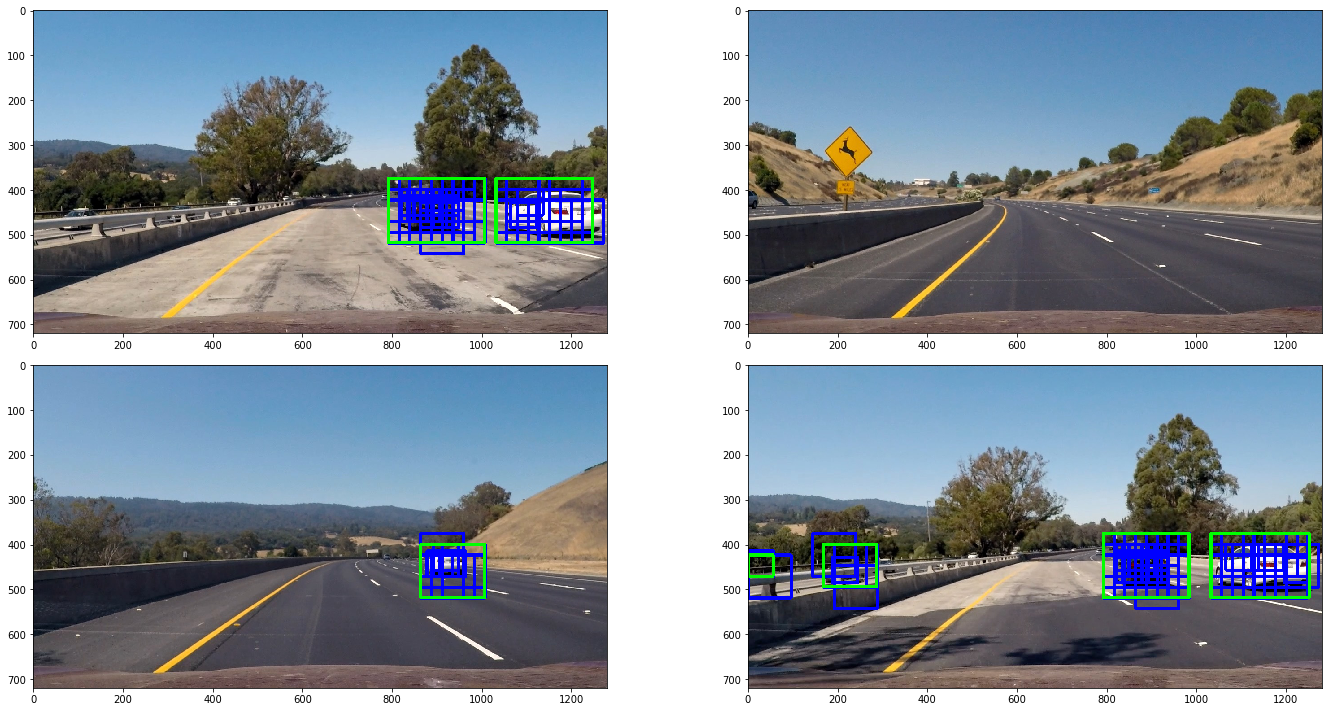

In [6]:

# optional, verify find_vehicles_boundary_multiple_scales()
def process_image_test(img):
    draw_img, boundary_list = find_vehicles_boundary_multiple_scales(img, multiple_scales_set, draw=True)
    
    return draw_img
    
# verify test images
test_images = np.empty(4, dtype=object)
test_images[0] = mpimg.imread('./test_images/test1.jpg')
test_images[1] = mpimg.imread('./test_images/test2.jpg')
test_images[2] = mpimg.imread('./test_images/test3.jpg')
test_images[3] = mpimg.imread('./test_images/test4.jpg')

result_images = np.empty(6, dtype=object)
boundary_list = []

for i in range(4):
    result_images[i] = process_image_test(test_images[i])  
f, ax = plt.subplots(2, 2, figsize=(20, 10))
f.tight_layout()
ax[0, 0].imshow(result_images[0])
ax[0, 1].imshow(result_images[1])
ax[1, 0].imshow(result_images[2])
ax[1, 1].imshow(result_images[3])


C:\Users\xgu3\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


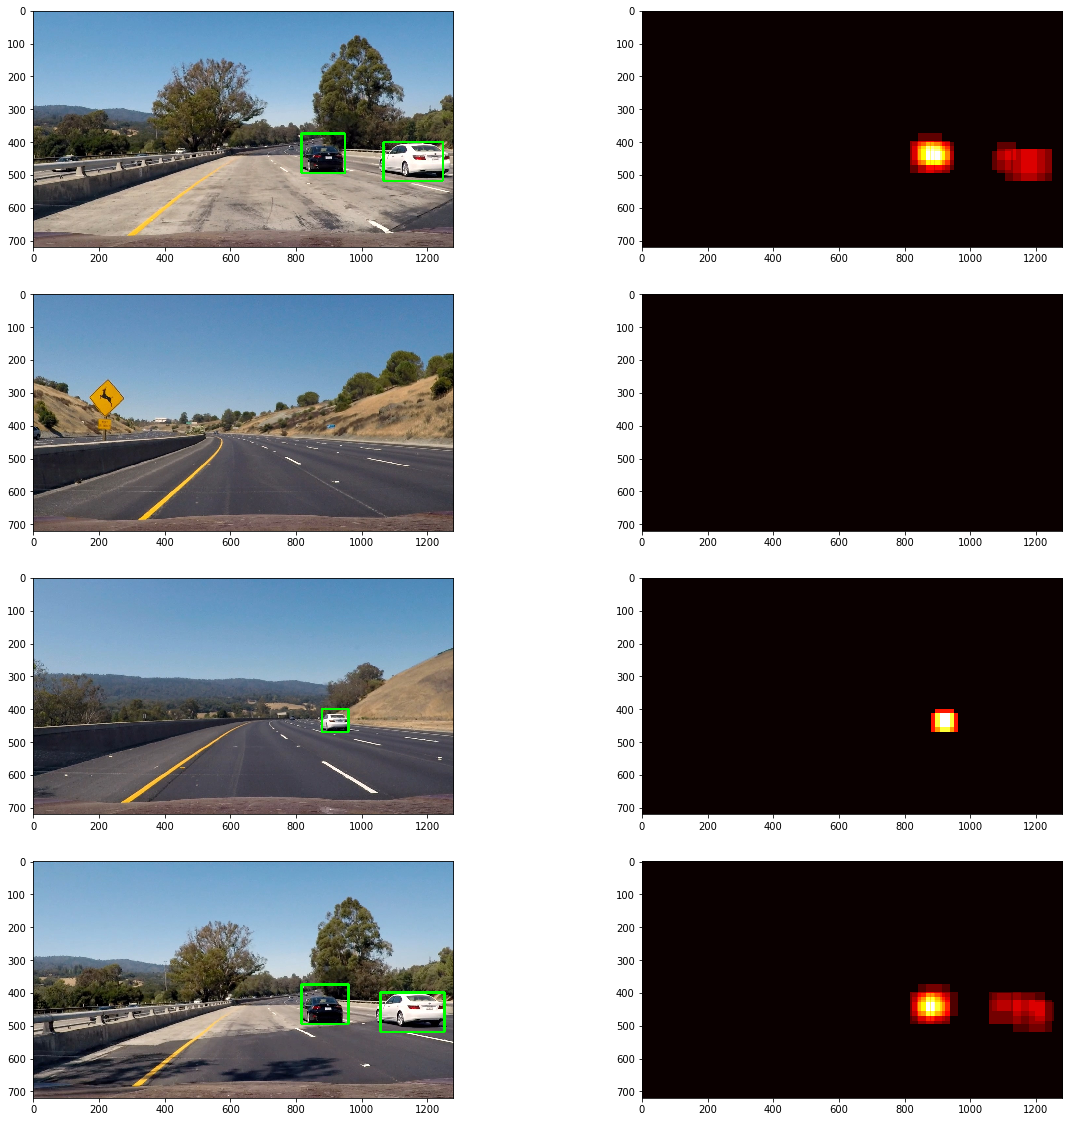

In [7]:
# optional, verify find_cars_multiple_scales() and heatmaps

def draw_box(img, box_lists):
    draw_img = np.copy(img)
    
    for box in box_lists:
        cv2.rectangle(draw_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0, 0, 255), 6)         
    
    return draw_img
   
# verify test images
count_img = 4
test_images = np.empty(count_img, dtype=object)
test_images[0] = mpimg.imread('./test_images/test1.jpg')
test_images[1] = mpimg.imread('./test_images/test2.jpg')
test_images[2] = mpimg.imread('./test_images/test3.jpg')
test_images[3] = mpimg.imread('./test_images/test4.jpg')

result_images = np.empty(count_img, dtype=object)
heap_maps = np.empty(count_img, dtype=object)
box_lists = np.empty(count_img, dtype=object)

for i in range(count_img):
    box_lists = []
    
    for (ystart, ystop, scale) in multiple_scales_set:
        image, new_box_list = find_cars_multiple_scales(test_images[i], ystart, ystop, scale, svc, X_scaler, orient,
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_lists += new_box_list
    
    result_images[i] = draw_box(test_images[i], box_lists)
    
    heat = np.zeros_like(test_images[i][:, :, 0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_lists)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heap_maps[i] = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heap_maps[i])
    result_images[i], boundary_list = draw_labeled_bboxes(np.copy(test_images[i]), labels)
  
f, ax = plt.subplots(count_img, 2, figsize=(20, 20))
ax[0, 0].imshow(result_images[0])
ax[0, 1].imshow(heap_maps[0], cmap='hot')
ax[1, 0].imshow(result_images[1])
ax[1, 1].imshow(heap_maps[1], cmap='hot')
ax[2, 0].imshow(result_images[2])
ax[2, 1].imshow(heap_maps[2], cmap='hot')
ax[3, 0].imshow(result_images[3])
ax[3, 1].imshow(heap_maps[3], cmap='hot')


## Step 4 Run pipeline on a video stream

In [8]:

def cal_centroid(boundary):
    return (int((boundary[0][0] + boundary[1][0]) / 2), int((boundary[0][1] + boundary[1][1]) / 2))

# Define a class to record vehicles info
class Vehicle():
    def __init__(self):        
        self.boundary = ((0, 0), (0, 0))
        self.centroid = (0, 0)
        self.live_frames = 0
        self.current_match = False
        self.dilute_centroid = (0, 0)
        self.dilute_boundary = ((0, 0), (0, 0))
    
from numpy import sqrt
import scipy.misc

# calculate the distance between 2 points
def distance(v1, v2):
    x = v1[0] - v2[0]
    y = v1[1] - v2[1]
    return sqrt(pow(x, 2) + pow(y, 2))

def process_image_multiple_scales(img):
    
    global frame_counter
       
    logging.debug('start new frame {:4.2f}'.format(frame_counter * slice_of_time) + ' index ' + str(frame_counter))
    frame_counter += 1    
    boundary_list = []
    is_draw = False
    #img = np.copy(in_img)     
    result_images, boundary_list = find_vehicles_boundary_multiple_scales(img, multiple_scales_set, draw=False)
    count_detected_v = len(detected_vehicles)
    count_new_v = len(boundary_list)
    
    logging.debug('  boundary list length ' + str(count_new_v))
    logging.debug('  detected vehicles length ' + str(count_detected_v))
    
    # if there're vehicle detected before
    if(count_detected_v > 0):        
        for boundary in boundary_list:
            match = False
            mean_distance = 0
            center = cal_centroid(boundary)
                            
            logging.debug('  new boundary ')
            logging.debug('  center' + str(center))
            logging.debug('  boundary ' + str(boundary))
                    
            for i  in range(count_detected_v): 
                detected_v = detected_vehicles[i]
                offset = distance(center, detected_v.centroid)
                mean_distance += offset
                
                logging.debug('    detected_v ' + str(i))            
                logging.debug('    detected_v.centroid ' + str(detected_v.centroid))
                logging.debug('    detected_v.boundary ' + str(detected_v.boundary))
                logging.debug('    distance ' + str(offset))
                
                # if new detected box is close to a detected vehicle
                if offset < centeroid_margin:
                    match = True
                    detected_v.live_frames += 1
                    detected_v.current_match = True
                    
                    logging.debug('    match detected_v.live_frames ' + str(detected_v.live_frames))          
                    
                    if (detected_v.dilute_boundary[0][0] != 0):
                        logging.debug('    match detected_v.live_frames ' + str(detected_v.live_frames))  
                            
                        if smooth == 'Average':
                            detected_v.dilute_centroid = (int((detected_v.dilute_centroid[0] + center[0]) / 2), \
                                                          int((detected_v.dilute_centroid[1] + center[1]) / 2))
                            detected_v.dilute_boundary = ((int((detected_v.dilute_boundary[0][0] + boundary[0][0]) / 2), \
                                                           int((detected_v.dilute_boundary[0][1] + boundary[0][1]) / 2)), \
                                                            (int((detected_v.dilute_boundary[1][0] + boundary[1][0]) / 2), \
                                                            int((detected_v.dilute_boundary[1][1] + boundary[1][1]) / 2)))
                        
                            logging.debug('    Average') 
                        if smooth == 'Max':
                            detected_v.dilute_boundary = ((min(detected_v.dilute_boundary[0][0], boundary[0][0]), \
                                                       min(detected_v.dilute_boundary[0][1], boundary[0][1])), \
                                                      (max(detected_v.dilute_boundary[1][0], boundary[1][0]), \
                                                       max(detected_v.dilute_boundary[1][1], boundary[1][1])))
                            logging.debug('    Max') 
                    else:
                        detected_v.dilute_boundary = boundary
                    detected_v.dilute_centroid = cal_centroid(detected_v.dilute_boundary)
                    
                    if (detected_v.live_frames > wiggling_threashold):
                        # calculate mean last and current frame boundaries to reduce wiggling
                        detected_v.live_frames = detection_threashold + 1
                        detected_v.centroid = detected_v.dilute_centroid
                        detected_v.boundary = detected_v.dilute_boundary
                        detected_v.dilute_boundary = boundary
                        detected_v.dilute_centroid = center
                                                
                        logging.debug('    average detected_v.centroid' + str(detected_v.centroid))
                        logging.debug('    average detected_v.boundary' + str(detected_v.boundary))
                        logging.debug('    live frames decreased to' + str(detected_v.live_frames))
                    
                    logging.debug('    break')
                    break    
            
            # if new detected box isn't close to any detected vehicle,but the distance is shorter than 
            # distance_threshold, put it in temp list
            mean_distance = mean_distance / (i + 1)
            if (match == False) and (mean_distance < distance_threshold):
                new_vehicle = Vehicle()
                new_vehicle.centroid = center
                new_vehicle.boundary = boundary
                new_vehicle.live_frames = 1
                new_vehicle.current_match = True
                detected_vehicles.append(new_vehicle)
               
                logging.debug('  new vehicle found')
                logging.debug('  new_vehicle.centroid ' + str(new_vehicle.centroid))
                logging.debug('  new_vehicle.boundary ' + str(new_vehicle.boundary))
            else:
                logging.debug('  match or new faraway vehicle removed')
        
        count_detected_v = len(detected_vehicles)
        
        logging.debug('start detected_vehicles')
        logging.debug('length ' + str(len(detected_vehicles)))
        i = 0
        
        # go through all detected vehicles
        while i < len(detected_vehicles):
            logging.debug('  detected_vehicle ' + str(i))
            logging.debug('  centroid ' + str(detected_vehicles[i].centroid))
            logging.debug('  boundary ' + str(detected_vehicles[i].boundary))
            logging.debug('  live_frames ' + str(detected_vehicles[i].live_frames))
            logging.debug('  current_match ' + str(detected_vehicles[i].current_match))            
            
            # if the live frame > detection_threashold, display a box aound the vehicle
            if detected_vehicles[i].live_frames >= detection_threashold:                        
                cv2.rectangle(result_images, detected_vehicles[i].boundary[0], detected_vehicles[i].boundary[1], (0, 255, 0), 3)
                logging.debug('  draw')
                is_draw = True
                
            # no new box match to detected vehicles,decrease its live frames
            if  detected_vehicles[i].current_match == False:
                if detected_vehicles[i].live_frames > 2 * detection_threashold:
                    # the unmatch detected vehicle will be displayed in next detection_threashold frames, no matter how
                    # many frames i was displayed before
                    detected_vehicles[i].live_frames = 2 * detection_threashold - 1
                else:
                    detected_vehicles[i].live_frames -= 1
                logging.debug('  live')
            
            # if live frame decrease to zero, remove it
            if detected_vehicles[i].live_frames <= 0:
                detected_vehicles.pop(i)
                logging.debug('  pop')
            else: 
                # prepare for next frame
                detected_vehicles[i].current_match = False
                i += 1
    # if no new box is drawed in this round
    if (is_draw == False):
        #scipy.misc.imsave('Blank {:4.2f}'.format((frame_counter - 1) * slice_of_time) + '.png', in_img)
        logging.debug('Blank')
        
        # if no detected vehicle in previous frame, add new box to temp list
        if (count_detected_v == 0):
            logging.debug('Disply new vehicles directly')
            for boundary in boundary_list:
                new_vehicle = Vehicle()
                new_vehicle.centroid = cal_centroid(boundary)
                new_vehicle.boundary = boundary
                new_vehicle.live_frames = 1
                detected_vehicles.append(new_vehicle)
        
        # if new box is zero, keep detected vehicles for current frame
        if (count_new_v == 0):
            logging.debug('Disply existing vehicles directly')            
            for vehicle in detected_vehicles:   
                vehicle.live_frames += 1
    
    logging.debug('end detected_vehicles')
    logging.debug('end new frame')
        
    return result_images


In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time

logging.basicConfig(filename='./ad.log', level=logging.ERROR)
detected_vehicles = []
frame_counter = 0
slice_of_time = 0.04

logging.debug('new log start ' + time.strftime('%X %x'))
video_output_vd = "./test_video_vd.mp4"
clip1 = VideoFileClip("./test_video.mp4")
white_clip1 = clip1.fl_image(process_image_multiple_scales)
%time white_clip1.write_videofile(video_output_vd, audio=False)
clip1.reader.close()
logging.debug('new log end ' + time.strftime('%X %x'))

[MoviePy] >>>> Building video ./test_video_vd.mp4
[MoviePy] Writing video ./test_video_vd.mp4


 97%|████████████████████████████████████████████████████████████████████████████████▊  | 38/39 [00:37<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_vd.mp4 

Wall time: 39 s


In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time

logging.basicConfig(filename='./ad.log', level=logging.ERROR)
detected_vehicles = []
frame_counter = 0
slice_of_time = 0.04

logging.debug('new log start ' + time.strftime('%X %x'))
video_output_vd = "./project_video_vd.mp4"
#clip1 = VideoFileClip("./project_video.mp4").subclip(2,12)
clip1 = VideoFileClip("./project_video.mp4")
white_clip1 = clip1.fl_image(process_image_multiple_scales)
%time white_clip1.write_videofile(video_output_vd, audio=False)
clip1.reader.close()
logging.debug('new log end ' + time.strftime('%X %x'))

[MoviePy] >>>> Building video ./project_video_vd.mp4
[MoviePy] Writing video ./project_video_vd.mp4


100%|██████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [18:17<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_vd.mp4 

Wall time: 18min 18s


In [ ]:
# Optional, utility to extract single frame from video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
slice_of_time = 0.04
# extract specific frames, fps 25
clip1 = VideoFileClip("./project_video_vd.mp4")
time = 37
frames = 75
for i in range(frames):
    clip1.save_frame('./project_video_vd_t_{:4.2f}'.format(time + i * slice_of_time) + '.png', time + i * slice_of_time)
clip1.reader.close()

print('Done')


## Step 5 Add lane line detection

In [10]:
# library functions

import pickle
import numpy as np
import cv2
import glob
import csv

# load factors
pf = open('./data.p', "rb")
data = pickle.load(pf)
mtx = data['mtx']
dist = data['dist']
M = data['Transform']

# define global parameters
search_window_n = 9
search_window_margin = 50
search_recenter_pixels = 50
keep_last_n = 6  # use keep_last_n frames' data to smooth the curve
curvature_margin = 5000  # if the curvature difference of left and right lanes < curvature_margin, process it as normal
parallel_margin = 0.0003  # if the slope of left and right lanes < parallel_margin, process it as normal
# Lane_width_margin = 5
slice_of_time = 0.04  # Use to generate debug data for fps 25
debug = False

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Calculate gradient direction
    # Apply threshold
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

# Find polynomial from ground
def FindPolynomial(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0) 
    # plt.plot(histogram)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = search_window_n
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = search_window_margin
    # Set minimum number of pixels found to recenter window
    minpix = search_recenter_pixels
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 
        
        # Debug code
        # plt.imshow(out_img)
        # plt.savefig('out_img' + str(window) + '.png')

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    # debug code
    # binary_warped = warped_c
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # calculate car offset from center
    lane_midpoint = (left_fitx[-1] + right_fitx[-1]) / 2
    road_center = binary_warped.shape[1] / 2
    car_offset = (road_center - lane_midpoint) * xm_per_pix    

    return left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset

# Find polynomial based on previous frame
def FindNextPolynomial(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = search_window_margin
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + 
    left_fit[1] * nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + 
    right_fit[1] * nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # calculate car offset from center
    lane_midpoint = (left_fitx[-1] + right_fitx[-1]) / 2
    road_center = binary_warped.shape[1] / 2
    car_offset = (road_center - lane_midpoint) * xm_per_pix

    return left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, result, car_offset

def MeasureCurvature(left_fit, right_fit, leftx, lefty, rightx, righty, ploty):
   
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

    return left_curverad, right_curverad

def WarpBack(original_image, warped_c, M, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_c).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float') 
        
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # frame time in video
        self.time = 0
        
        self.ploty = None

def process_image(image):   
    
    image = process_image_multiple_scales(image)
    
    # step 1 Apply a distortion correction
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # step 2 Use color transforms, gradients, etc., to create a thresholded binary image    
    grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20, 100))

    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(grad_binary_x), grad_binary_x, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_binary_x)
    combined_binary[(s_binary == 1) | (grad_binary_x == 1)] = 1   
  
    # step 3 Apply a perspective transform to rectify binary image
    warped_c = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # step 4 Detect lane pixels and fit to find the lane boundary
    if line_l.detected == True and line_r.detected == True:
        left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset = \
            FindNextPolynomial(warped_c, line_l.current_fit, line_r.current_fit)
    else:
        left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset = \
            FindPolynomial(warped_c)

    # step 5 Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad = MeasureCurvature(left_fit, right_fit, leftx, lefty, rightx, righty, ploty)      
    
    # step 5.1 record info of each frame before modification
    if (debug == True):
        if (csv_writer_o != None):
            csv_writer_o.writerow(['{:4.2f}'.format(line_l.time)] \
                               + [left_curverad - right_curverad] + [left_fit[0] - right_fit[0]] + [left_fit[0] / right_fit[0]] \
                               + [car_offset] + [left_curverad] + [right_curverad] \
                               + [left_fit[0]] + [right_fit[0]] + [left_fit[1]] + [right_fit[1]] + [left_fit[2]] + [right_fit[2]] \
                               + [left_fit[1] - right_fit[1]] + [left_fit[2] - right_fit[2]] \
                               + [left_fit[1] / right_fit[1]] + [left_fit[2] / right_fit[2]])

    # step 5.2 Sanity check
    # if curvzture changes too much, skip it
    # if left and right fit is not parallel, skip it
    if (line_l.detected == True and line_r.detected == True) and \
        (abs(left_curverad - right_curverad) > curvature_margin \
        or abs(left_fit[0] - right_fit[0]) > parallel_margin): 
            left_curverad = line_l.radius_of_curvature
            right_curverad = line_r.radius_of_curvature
            left_fit = line_l.current_fit
            right_fit = line_r.current_fit
            left_fitx = line_l.allx
            right_fitx = line_r.allx
            ploty = line_l.ploty

    if (debug == True):
        if (csv_writer_m != None):
            csv_writer_m.writerow(['{:4.2f}'.format(line_l.time)] \
                               + [left_curverad - right_curverad] + [left_fit[0] - right_fit[0]] + [left_fit[0] / right_fit[0]] 
                               + [car_offset] + [left_curverad] + [right_curverad] \
                               + [left_fit[0]] + [right_fit[0]] + [left_fit[1]] + [right_fit[1]] + [left_fit[2]] + [right_fit[2]] \
                               + [left_fit[1] - right_fit[1]] + [left_fit[2] - right_fit[2]] \
                               + [left_fit[1] / right_fit[1]] + [left_fit[2] / right_fit[2]])
    line_l.time = line_l.time + slice_of_time
        
    # step 5.3 smooth by the average of last n frames' x 
    if line_l.detected == True and line_r.detected == True:
        if (len(line_l.recent_xfitted) < keep_last_n):
            line_l.recent_xfitted.append(left_fitx)
        else:
            line_l.recent_xfitted.pop(0)
            line_l.recent_xfitted.append(left_fitx)

        if (len(line_r.recent_xfitted) < keep_last_n):
            line_r.recent_xfitted.append(right_fitx)
        else:
            line_r.recent_xfitted.pop(0)
            line_r.recent_xfitted.append(right_fitx)

        left_fitx = line_l.recent_xfitted[0]
        right_fitx = line_r.recent_xfitted[0]
        if (len(line_l.recent_xfitted) == (keep_last_n)):       
            for i in range(keep_last_n - 1):
                left_fitx = left_fitx + line_l.recent_xfitted[i + 1]
                right_fitx = right_fitx + line_r.recent_xfitted[i + 1]
            left_fitx = left_fitx / keep_last_n
            right_fitx = right_fitx / keep_last_n

    # step 6 Warp the detected lane boundaries back onto the original image
    result = WarpBack(undist, warped_c, M, left_fitx, right_fitx, ploty)
    
    # step 7 record line info
    line_l.detected = True
    line_r.detected = True
    line_l.current_fit = left_fit
    line_r.current_fit = right_fit
    line_l.radius_of_curvature = left_curverad
    line_r.radius_of_curvature = right_curverad
    line_l.allx = left_fitx
    line_r.allx = right_fitx
    line_l.ploty = ploty
    line_r.ploty = ploty
    
     
       
    return result


In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import csv

import time

logging.basicConfig(filename='./ad.log', level=logging.ERROR)
detected_vehicles = []
frame_counter = 0
slice_of_time = 0.04

logging.debug('new log start ' + time.strftime('%X %x'))

# clear line record
line_l = Line()
line_r = Line()

csvfile_o = open('process_image_data_orig.csv', 'w')
csv_writer_o = csv.writer(csvfile_o, delimiter=',', lineterminator='\n')

csvfile_m = open('process_image_data_modify.csv', 'w')
csv_writer_m = csv.writer(csvfile_m, delimiter=',', lineterminator='\n')

white_output = './project_video_all.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

csvfile_o.close()
csvfile_m.close()

clip1.reader.close()
logging.debug('new log end ' + time.strftime('%X %x'))


[MoviePy] >>>> Building video ./project_video_all.mp4
[MoviePy] Writing video ./project_video_all.mp4


100%|██████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:00<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_all.mp4 

Wall time: 21min 1s
